In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sksurv
import sksurv.datasets
from sksurv.nonparametric import kaplan_meier_estimator

# Charger le dataset veterans_lung_cancer
X, y = sksurv.datasets.load_veterans_lung_cancer()

print("Shape du dataset X:", X.shape)
print("Colonnes disponibles:", X.columns.tolist())
print("Premières lignes de X:")
print(X.head())
print("\nInformations sur y (survie):")
print(y[:5])
print(f"Type de y: {type(y)}")
print(f"Structure de y: {y.dtype}")



Shape du dataset X: (137, 6)
Colonnes disponibles: ['Age_in_years', 'Celltype', 'Karnofsky_score', 'Months_from_Diagnosis', 'Prior_therapy', 'Treatment']
Premières lignes de X:
   Age_in_years  Celltype  Karnofsky_score  Months_from_Diagnosis  \
0          69.0  squamous             60.0                    7.0   
1          64.0  squamous             70.0                    5.0   
2          38.0  squamous             60.0                    3.0   
3          63.0  squamous             60.0                    9.0   
4          65.0  squamous             70.0                   11.0   

  Prior_therapy Treatment  
0            no  standard  
1           yes  standard  
2            no  standard  
3           yes  standard  
4           yes  standard  

Informations sur y (survie):
[( True,  72.) ( True, 411.) ( True, 228.) ( True, 126.) ( True, 118.)]
Type de y: <class 'numpy.ndarray'>
Structure de y: [('Status', '?'), ('Survival_in_days', '<f8')]


In [40]:
# Ajuster l'estimateur de Kaplan-Meier
# Pour veterans_lung_cancer, les colonnes sont 'Status' et 'Survival_in_days'
time, survival_prob = kaplan_meier_estimator(y['Status'], y['Survival_in_days'])

print(f"Nombre de points temporels: {len(time)}")
print(f"Probabilité de survie initiale: {survival_prob[0]:.4f}")
print(f"Probabilité de survie finale: {survival_prob[-1]:.4f}")
print(f"Temps minimum: {time[0]:.2f} jours")
print(f"Temps maximum: {time[-1]:.2f} jours")
print(f"Nombre total de patients: {len(y)}")
print(f"Événements observés (décès): {np.sum(y['Status'])}")
print(f"Censures: {len(y) - np.sum(y['Status'])}")


Nombre de points temporels: 101
Probabilité de survie initiale: 0.9854
Probabilité de survie finale: 0.0000
Temps minimum: 1.00 jours
Temps maximum: 999.00 jours
Nombre total de patients: 137
Événements observés (décès): 128
Censures: 9


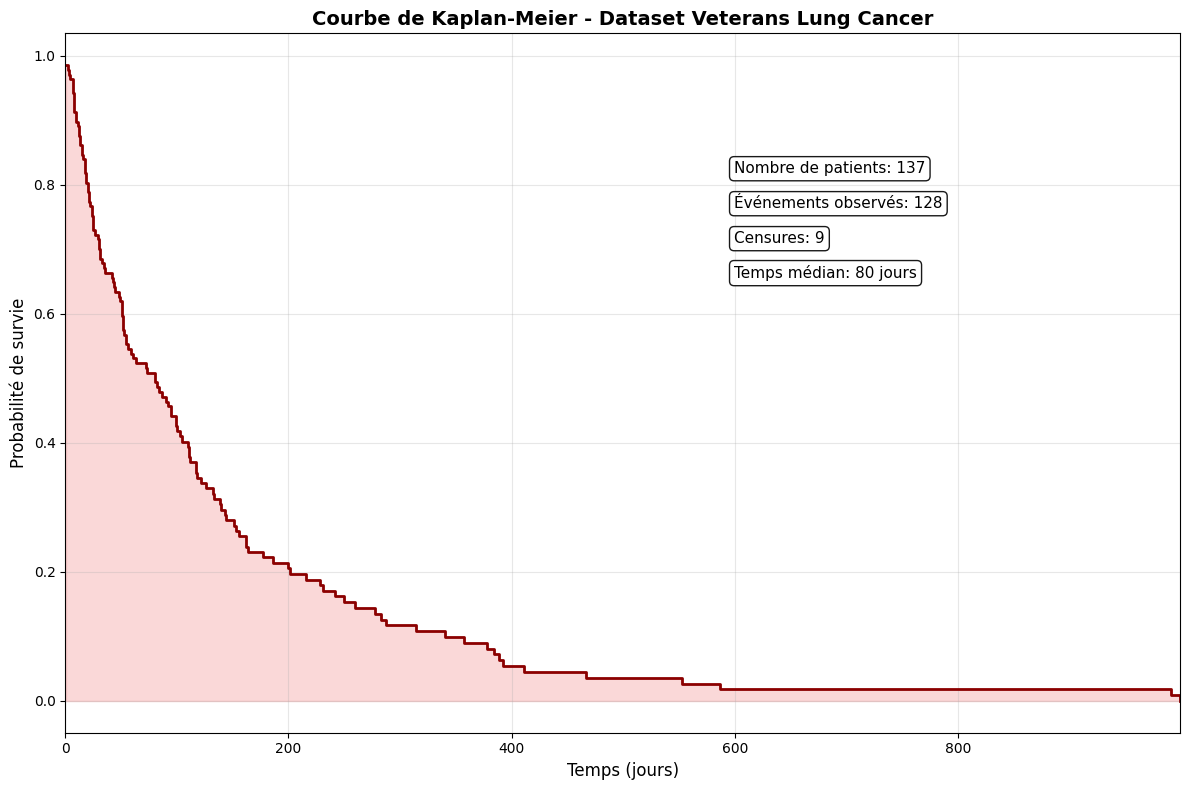

In [41]:
# Afficher la courbe de Kaplan-Meier
plt.figure(figsize=(12, 8))
plt.step(time, survival_prob, where="post", linewidth=2, color='darkred')
plt.fill_between(time, survival_prob, step="post", alpha=0.3, color='lightcoral')

plt.xlabel('Temps (jours)', fontsize=12)
plt.ylabel('Probabilité de survie', fontsize=12)
plt.title('Courbe de Kaplan-Meier - Dataset Veterans Lung Cancer', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xlim(0, time[-1])

# Ajouter des informations statistiques
plt.text(0.6, 0.8, f'Nombre de patients: {len(y)}', 
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
plt.text(0.6, 0.75, f'Événements observés: {np.sum(y["Status"])}', 
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
plt.text(0.6, 0.7, f'Censures: {len(y) - np.sum(y["Status"])}', 
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
plt.text(0.6, 0.65, f'Temps médian: {time[np.where(survival_prob <= 0.5)[0][0]]:.0f} jours', 
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))

plt.tight_layout()
plt.show()


In [42]:
# Import de lifelines pour le modèle de Cox
from lifelines import CoxPHFitter
import pandas as pd

# Préparer les données pour lifelines
# Créer un DataFrame avec les variables de survie et les covariables
df_survival = pd.DataFrame({
    'duration': y['Survival_in_days'],  # Temps de survie
    'event': y['Status'],              # Événement (True = décès, False = censure)
    'Age_in_years': X['Age_in_years'],
    'Karnofsky_score': X['Karnofsky_score'],
    'Months_from_Diagnosis': X['Months_from_Diagnosis']
})

# Encoder les variables binaires
# Treatment: standard = 0, test = 1
df_survival['Treatment_encoded'] = (X['Treatment'] == 'test').astype(int)

# Prior_therapy: no = 0, yes = 1  
df_survival['Prior_therapy_encoded'] = (X['Prior_therapy'] == 'yes').astype(int)

# Encoder Celltype en variables dummy
celltype_dummies = pd.get_dummies(X['Celltype'], prefix='Celltype')
df_survival = pd.concat([df_survival, celltype_dummies], axis=1)

print("DataFrame préparé pour lifelines:")
print(df_survival.head())
print(f"\nShape du DataFrame: {df_survival.shape}")
print(f"Colonnes: {df_survival.columns.tolist()}")


DataFrame préparé pour lifelines:
   duration  event  Age_in_years  Karnofsky_score  Months_from_Diagnosis  \
0      72.0   True          69.0             60.0                    7.0   
1     411.0   True          64.0             70.0                    5.0   
2     228.0   True          38.0             60.0                    3.0   
3     126.0   True          63.0             60.0                    9.0   
4     118.0   True          65.0             70.0                   11.0   

   Treatment_encoded  Prior_therapy_encoded  Celltype_adeno  Celltype_large  \
0                  0                      0           False           False   
1                  0                      1           False           False   
2                  0                      0           False           False   
3                  0                      1           False           False   
4                  0                      1           False           False   

   Celltype_smallcell  Celltype_sq

In [52]:
# Créer et ajuster le modèle de Cox
cph = CoxPHFitter()

# Définir les covariables à inclure dans le modèle (sans Treatment)
covariates = [
    'Age_in_years',
    'Karnofsky_score', 
    'Months_from_Diagnosis',
    'Prior_therapy_encoded',
    'Celltype_adeno',
    'Celltype_large',
    'Celltype_smallcell',
    'Celltype_squamous'
]

# Ajuster le modèle de Cox
cph.fit(df_survival.drop("Treatment_encoded", axis="columns"), duration_col='duration', event_col='event')

print("Modèle de Cox ajusté avec succès!")
print(f"Nombre d'observations: {cph.n_observations_}")
print(f"Nombre d'événements: {cph.n_events_}")
print(f"Log-likelihood: {cph.log_likelihood_:.4f}")
print(f"AIC: {cph.AIC_:.4f}")
print(f"Concordance index: {cph.concordance_index_:.4f}")


ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

In [ ]:
# Afficher les résultats détaillés du modèle
print("="*60)
print("RÉSULTATS DU MODÈLE DE COX")
print("="*60)

# Résumé du modèle
print("\n1. RÉSUMÉ DU MODÈLE:")
cph.print_summary()

print("\n" + "="*60)
print("2. INTERPRÉTATION DES COEFFICIENTS:")
print("="*60)

# Afficher les coefficients avec interprétation
summary_df = cph.summary
for idx, row in summary_df.iterrows():
    coef = row['coef']
    hazard_ratio = np.exp(coef)
    p_value = row['p']
    
    print(f"\n{idx}:")
    print(f"  Coefficient: {coef:.4f}")
    print(f"  Hazard Ratio (HR): {hazard_ratio:.4f}")
    print(f"  P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        significance = "***"
    elif p_value < 0.01:
        significance = "**"
    elif p_value < 0.1:
        significance = "*"
    else:
        significance = ""
    
    print(f"  Significativité: {significance}")
    
    # Interprétation du hazard ratio
    if hazard_ratio > 1:
        print(f"  → Augmente le risque de décès de {(hazard_ratio-1)*100:.1f}%")
    elif hazard_ratio < 1:
        print(f"  → Diminue le risque de décès de {(1-hazard_ratio)*100:.1f}%")
    else:
        print(f"  → Pas d'effet sur le risque de décès")


In [ ]:
# Visualisation des résultats
print("\n" + "="*60)
print("3. VISUALISATION DES RÉSULTATS:")
print("="*60)

# Graphique des hazard ratios avec intervalles de confiance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique 1: Hazard ratios
hazard_ratios = np.exp(summary_df['coef'])
ci_lower = np.exp(summary_df['coef'] - 1.96 * summary_df['se(coef)'])
ci_upper = np.exp(summary_df['coef'] + 1.96 * summary_df['se(coef)'])

y_pos = np.arange(len(summary_df))
ax1.errorbar(hazard_ratios, y_pos, xerr=[hazard_ratios - ci_lower, ci_upper - hazard_ratios], 
             fmt='o', capsize=5, capthick=2)
ax1.axvline(x=1, color='red', linestyle='--', alpha=0.7)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(summary_df.index)
ax1.set_xlabel('Hazard Ratio')
ax1.set_title('Hazard Ratios avec Intervalles de Confiance')
ax1.grid(True, alpha=0.3)

# Graphique 2: P-values
p_values = summary_df['p']
colors = ['red' if p < 0.05 else 'orange' if p < 0.1 else 'blue' for p in p_values]
bars = ax2.barh(y_pos, -np.log10(p_values), color=colors, alpha=0.7)
ax2.axvline(x=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='p=0.05')
ax2.axvline(x=-np.log10(0.01), color='darkred', linestyle='--', alpha=0.7, label='p=0.01')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(summary_df.index)
ax2.set_xlabel('-log10(p-value)')
ax2.set_title('Significativité des Variables')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Résumé des variables significatives
print("\n4. VARIABLES SIGNIFICATIVES (p < 0.05):")
significant_vars = summary_df[summary_df['p'] < 0.05]
if len(significant_vars) > 0:
    for idx, row in significant_vars.iterrows():
        hr = np.exp(row['coef'])
        print(f"  • {idx}: HR = {hr:.3f}, p = {row['p']:.4f}")
else:
    print("  Aucune variable significative au seuil de 5%")
